In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro
from pyro.distributions import (
    Bernoulli,
    Beta,
    Binomial,
    Categorical,
    Normal,
    Uniform,
)
from sklearn.linear_model import LinearRegression

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jun 24 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

matplotlib: 3.9.0
numpy     : 1.26.4
pandas    : 2.2.2
torch     : 2.3.0
pyro      : 1.9.1
scipy     : 1.12.0

Watermark: 2.4.3



### precis function

In [ ]:
def precis(samples: dict, prob=0.89):
    """Computes some summary statistics of the given samples.

    Arguments:
        samples (Dict[str, np.array]): dictionary of samples, where the key
            is the name of the sample site, and the value is the collection
            of sample values
        prob (float): the probability mass of the symmetric credible interval
    Returns:
        pd.DataFrame: summary dataframe
    """
    p1, p2 = (1-prob)/2, 1-(1-prob)/2
    cols = ["mean","stddev",f"{100*p1:.1f}%",f"{100*p2:.1f}%"]
    df = pd.DataFrame(columns=cols, index=samples.keys())
    if isinstance(samples, pd.DataFrame):
        samples = {k: np.array(samples[k]) for k in samples.columns}
    elif not isinstance(samples, dict):
        raise TypeError("<samples> must be either dict or DataFrame")
    for k, v in samples.items():
        df.loc[k,"mean"] = v.mean()
        df.loc[k,"stddev"] = v.std()
        q1, q2 = np.quantile(v, [p1, p2])
        df.loc[k,f"{100*p1:.1f}%"] = q1
        df.loc[k,f"{100*p2:.1f}%"] = q2
    return df


In [ ]:
%cd ~/Documents/Path-to-directory

### Code 0.1

In [ ]:
print("All models are wrong, but some are useful")

All models are wrong, but some are useful


### Code 0.2

10*20 = 200

In [ ]:
x = np.array([1, 2])
x = x*10
x = np.log(x)
x = np.sum(x)
x = np.exp(x)
x

199.99999999999991

### Code 0.3

Mathematically, the expressions
$$
p_1 = \log(0.01^{200}) \\
p_2 = 200 \times \log(0.01)
$$
are equivalent. However, if you compute them numerically, you will see that one is much more stable:

In [ ]:
print(np.log(0.01**200))
print(200*np.log(0.01))

-inf
-921.0340371976182


/tmp/ipykernel_13626/1372267074.py:1: RuntimeWarning: divide by zero encountered in log
  print(np.log(0.01**200))


### Code 0.4
Running linear regression on a sample dataset.

coefficients: [3.93240876]
intercept: -17.579094890510973


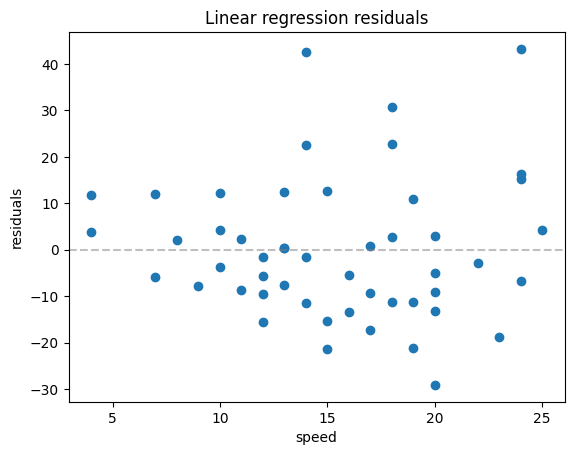

In [ ]:
# Import the data
cars = pd.read_csv(r"share/data/cars.csv")

# Fit a linear regression of distance on speed
model = LinearRegression()
X = cars["speed"].values.reshape(-1, 1)
y = cars["dist"].values
model.fit(X, y)

# Estimated coefficients from the model
print("coefficients:", model.coef_)
print("intercept:", model.intercept_)

# Plot residuals against speed
res = y - model.predict(X)
plt.scatter(cars["speed"], res)
plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
plt.title("Linear regression residuals")
plt.ylabel("residuals")
plt.xlabel("speed")
plt.show()

### Code 2.1

Normalize a list of counts to produce a probability distribution

In [ ]:
# samples = B, W, B
# n = 3
# W = 2

p = [0, 0.25, 0.5, 0.75, 1]
plausibility = [stats.binom(n=3, p=i).pmf(2) for i in p]
plausibility = np.array([p/sum(plausibility) for p in plausibility])
plausibility

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

In [ ]:

ways = np.array([0, 3, 8, 9, 0])
df = pd.DataFrame({"p": [0, 0.25, 0.5, 0.75, 1],
                   "ways": ways})
df["plausibility"] = ways/sum(ways)
df["plausibility_calculated"] = plausibility
df

,p,ways,plausibility,plausibility_calculated
0,0.00,0,0.00,0.00
1,0.25,3,0.15,0.15
2,0.50,8,0.40,0.40
3,0.75,9,0.45,0.45
4,1.00,0,0.00,0.00


### Code 2.2

Compute the likelihood of getting six successes in nine trials with a success probability of 50% using a binomial distribution.

In [ ]:
# Using scipy's stats module
p = stats.binom(n=9, p=0.5).pmf(6)


In [ ]:
# Using pyro's distributions
Binomial(total_count=9, probs=0.5).log_prob(torch.tensor(6.)).exp().item()


0.1640624701976776

In [ ]:

def generate_bernoulli_samples(p, N):
    b = Bernoulli(probs=p)
    samples_bernoulli = torch.tensor([b() for i in range(N)])
    return samples_bernoulli

#test extreme cases p=1
N = 10000
p = 1
samples_bernoulli = generate_bernoulli_samples(p, N)
W = (samples_bernoulli==1).sum()
L = (samples_bernoulli==0).sum()
p = W/N
print(W, L, p)

# test general case
N = 10000
p = 0.5
samples_bernoulli = generate_bernoulli_samples(p, N)
W = (samples_bernoulli==1).sum()
L = (samples_bernoulli==0).sum()
p = W/N
print(W, L, p)


tensor(10000) tensor(0) tensor(1.)
tensor(4973) tensor(5027) tensor(0.4973)


### Micro-steps to understand

The counts of “water” W and “land’ L are distributed binomially, with probability p of “water” on each toss
$$P(W, L|p) = \frac{(W+L)!}{W!L!} p^W (1-p)^L$$

[0.01640625] [0.01640625] 4.3999001173211843e-16


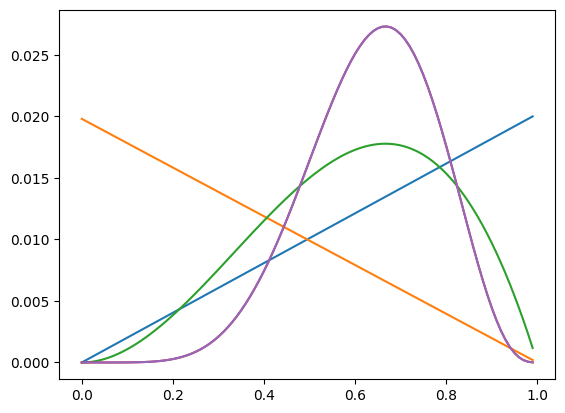

In [ ]:
# micro-steps in feynmans algorithm to better understanding
step = 0.01
eps = 0.000000001
p = np.arange(0,1, step)
W = np.arange(0,1, step)*2
L = np.arange(1,0,-step)*2

# bayesian updating style
y = W
plt.plot(p, y/y.sum())
y = L
plt.plot(p, y/y.sum())
y = W*L*W
plt.plot(p, y/y.sum())
y = W*L*W*W*W*L*W*L*W
y = y/y.sum()
plt.plot(p, y)

# Directly get the final posterior
y_stats = stats.binom(n=9, p=p).pmf(6)
y_stats = y_stats/y_stats.sum()
plt.plot(p, y_stats)
print(y_stats[p==0.5], y[p==0.5], np.linalg.norm(y-y_stats))

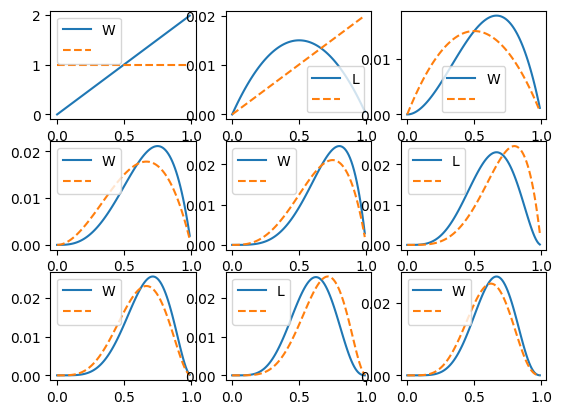

In [ ]:
# bayesian updating style
p = np.arange(0,1, 0.01)
W = np.arange(0,1, 0.01)*2
L = np.arange(1,0,-0.01)*2
y = W
y_old = np.ones(p.shape)
plt.show()
obs = ("W","L","W","W","W","L","W","L","W")
fig = plt.figure()
ax = fig.add_subplot(3, 3, 1)
for i in range(2,10):
    ax.plot(p, y)
    ax.plot(p, y_old, linestyle='dashed')
    ax.legend(f"{obs[i-2]} point")
    y_old = y/y.sum()
    ax = fig.add_subplot(3, 3, i)
    if obs[i-1] == "L":
        y = y*L
    if obs[i-1] =="W":
        y = y*W
    y = y/y.sum()
ax.plot(p, y)
ax.plot(p, y_old, linestyle='dashed')
ax.legend(f"{obs[-1]} point")

### Code 2.3
A model is born.
$$W \sim Binomial (N,p)\\
p \sim Uniform(0,1)$$
#### grid approximation

Coding the estimator. Using the "grid approximation" to condition models.

In [ ]:
# estimator
def count(p, W, N):
    L = N - W
    return ((4*p)**W) * ((4 - 4*p)**L)

def calc_posterior(n_points=20):
    # Define the grid
    p_grid = np.linspace(0, 1, n_points)
    # Define uniform prior (un-normalized)
    prior = np.ones(n_points)
    # Compute likelihood at each point
    likelihood = np.array([count(p, 6, 9) for p in p_grid])
    #likelihood = stats.binom(n=9, p=p_grid).pmf(6)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

### Code 2.4
Display the results of the above computation

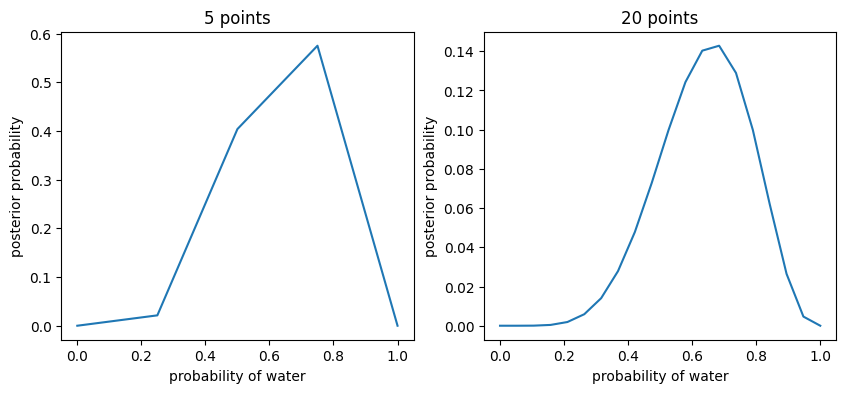

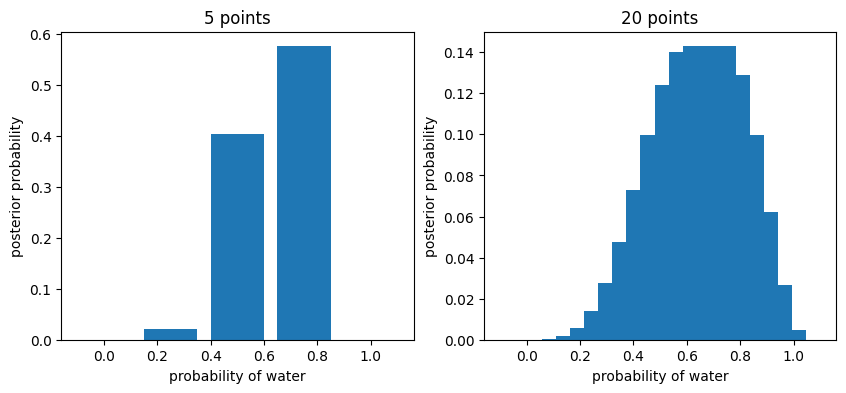

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for n, ax in zip((5, 20), axes):
    p_grid, posterior = calc_posterior(n)
    ax.plot(p_grid, posterior)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{n} points")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for n, ax in zip((5, 20), axes):
    p_grid, posterior = calc_posterior(n)
    ax.bar(p_grid, posterior, width=0.2)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{n} points")
#plt.subplots_adjust(wspace=0.5)
plt.show()

### Code 2.5
Do the same thing as above, but for some different priors

In [ ]:
def calc_posterior(prior):
    # Define the grid
    n_points = len(prior)
    p_grid = np.linspace(0, 1, n_points)
    # Compute likelihood at each point
    likelihood = np.array([count(p, 6, 9) for p in p_grid])
    #likelihood = stats.binom(n=9, p=p_grid).pmf(6)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, likelihood, posterior

Prior


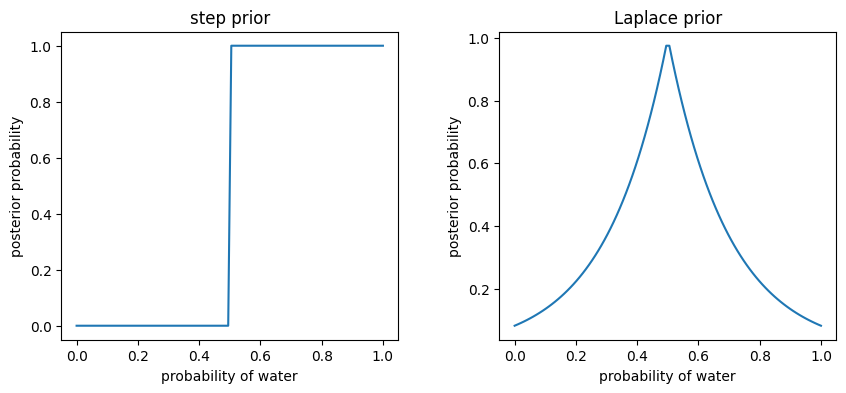

Likelihood


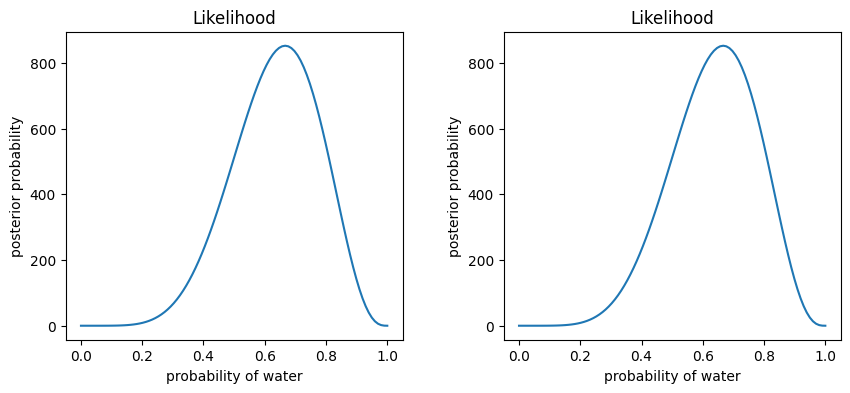

Posterior


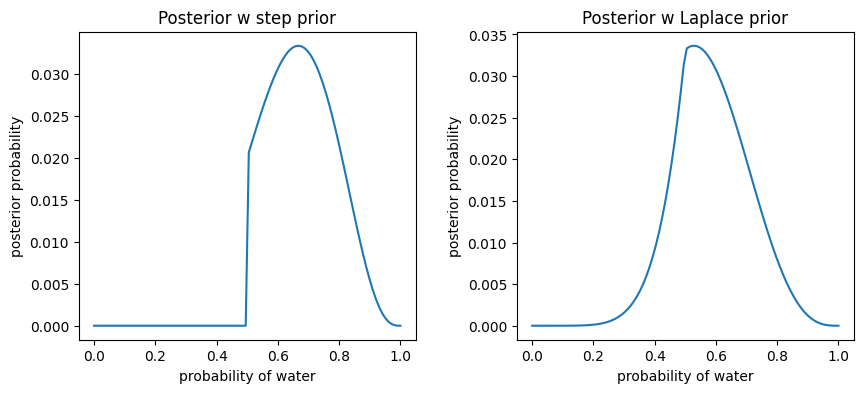

In [ ]:

n_points = 100
p_grid = np.linspace(0, 1, n_points)
priors = np.array([
    [0 if p < 0.5 else 1 for p in p_grid], # step function
    np.exp(-5*np.abs(p_grid - 0.5)), # Laplace prior
])


print("Prior")
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for prior, ax, label in zip(priors, axes, ("step", "Laplace")):
    ax.plot(p_grid, prior)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{label} prior")
plt.subplots_adjust(wspace=0.3)
plt.show()

print("Likelihood")
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for prior, ax, label in zip(priors, axes, ("step", "Laplace")):
    p_grid, likelihood, posterior = calc_posterior(prior)
    ax.plot(p_grid, likelihood)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"Likelihood")
plt.subplots_adjust(wspace=0.3)
plt.show()

print("Posterior")
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for prior, ax, label in zip(priors, axes, ("step", "Laplace")):
    p_grid, likelihood, posterior = calc_posterior(prior)
    ax.plot(p_grid, posterior)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"Posterior w {label} prior")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 2.6
#### quadratic approximation
#### grid approximation scales poorly with model complexity.

Compute the quadratic approximation (the posterior is approximated as a Gaussian centered on the MAP estimate) for the globe model:
$$
p \sim \text{Uniform}(0, 1) \\
W \sim \text{Binomial}(W+L, p) \\
\text{data: } W=6, L=3
$$
McElreath uses some black box function `quap` to perform the calculation. Since no equivalent function to `quap` exists in `pyro` (that I know of), we're just gonna have to roll our own. First we compute the MAP estimate for $p$ using vanilla gradient descent.
https://docs.pyro.ai/en/dev/poutine.html
https://docs.pyro.ai/en/dev/poutine.html#trace
https://pyro.ai/examples/effect_handlers.html
https://pyro4ci.readthedocs.io/en/latest/poutine.html

In [ ]:
# Specify the model
def model(W, L):
    N = pyro.deterministic("N", torch.tensor(W+L))

    p = pyro.sample("p", Uniform(0., 1.))

    # Condition on the observed value of W
    pyro.sample("W", Binomial(N, p), obs=torch.tensor(W))

In [ ]:
# First, we compute the MAP estimate
pyro.clear_param_store()

# Specify the model
def model(W, L):
    N = pyro.deterministic("N", torch.tensor(W+L))
    # p is an optimizable parameter instead of a sampled value
    p = pyro.param("p", Uniform(0., 1.).sample())
    # Condition on the observed value of W
    pyro.sample("W", Binomial(N, p), obs=torch.tensor(W))

# Trace the model so that we can inspect it when it runs
traced_model = pyro.poutine.trace(model)
vals = []
# Use vanilla gradient descent to maximize the likelihood
for _ in range(1000):
    tr = traced_model.get_trace(6., 3.)
    p = tr.nodes["p"]["value"]
    log_L = tr.log_prob_sum() # log likelihood
    log_L.backward() # Differentiate likelihood wrt parameters (p)
    p.data += 1e-3*p.grad # gradient update
    p.grad.zero_()
    vals.append(p.item())
print(f"MAP estimate: p={vals[-1]:.4f}")

MAP estimate: p=0.6667


In [ ]:
def estimator1(model):
    # Trace the model so that we can inspect it when it runs
    traced_model = pyro.poutine.trace(model)
    vals = []
    # Use vanilla gradient descent to maximize the likelihood
    for _ in range(1000):
        tr = traced_model.get_trace(6., 3.)
        p = tr.nodes["p"]["value"]
        log_L = tr.log_prob_sum() # log likelihood
        log_L.backward() # Differentiate likelihood wrt parameters (p)
        p.data += 1e-3*p.grad # gradient update
        p.grad.zero_()
        vals.append(p.item())
        return vals[-1]
print(f"MAP estimate: p={estimator1(model):.4f}")

MAP estimate: p=0.6667


param
sample


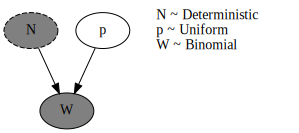

In [ ]:
#pyro.render_model(model, model_args=(data,))

tr = pyro.poutine.trace(model).get_trace(6., 3.)
print(tr.nodes["p"]["type"]) # param

model = pyro.poutine.lift(model, prior={"p": Uniform(0., 1.)})

tr = pyro.poutine.trace(model).get_trace(6., 3.)
print(tr.nodes["p"]["type"]) # sample

'''
# Specify the model
def model(W, L):
    #N = torch.tensor(W+L)
    N = pyro.deterministic("N", torch.tensor(W+L))
    # p is an optimizable parameter instead of a sampled value
    p = pyro.sample("p", Uniform(0., 1.))
    # Condition on the observed value of W
    pyro.sample("W", Binomial(N, p), obs=torch.tensor(W))
'''
pyro.render_model(model, model_args=(5 , 3,), render_params=True, render_distributions=True, render_deterministic=True)

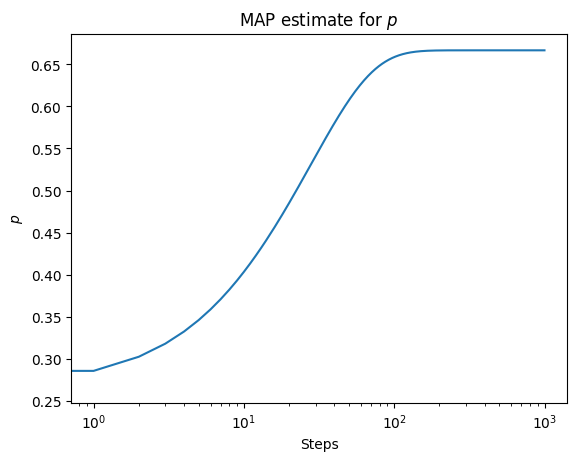

In [ ]:
plt.plot(vals)
plt.xscale('log')
plt.title("MAP estimate for $p$")
plt.xlabel("Steps")
plt.ylabel("$p$")
plt.show()

Then we compute the "curvature" at the peak in order to estimate the standard deviation. The reason why becomes apparent if you look at the log of the normal distribution:
$$
N(x;\mu,\sigma) \propto \exp\left(-(x-\mu)^2/2\sigma^2\right) \\
\log N(x; \mu,\sigma) = f(x) = -(x-\mu)^2/2\sigma^2 + C
$$
we can see that if we expand $f(x)$ around $x=\mu$ to second order, we recover the equation itself, because $f(x)$ is a parabola with
$$
f(\mu) = C,\quad f^\prime(\mu) = 0,\quad f^{\prime\prime}(\mu) = -1/\sigma^2
$$
so that the relationship between the second derivative and $\sigma$ is
$$
\sigma = 1/\sqrt{-f^{\prime\prime}(\mu)}
$$

In [ ]:
# Compute the "curvature" (second derivative) of the log
# likelihood wrt p
tr = traced_model.get_trace(6., 3.)
p = tr.nodes["p"]["value"]
log_L = tr.log_prob_sum()
# Compute the second derivative of the log likelihood wrt p
g = torch.autograd.grad(log_L, p, create_graph=True)[0]
g2 = torch.autograd.grad(g, p)[0]
print(f"2nd derivative is {g2.item():.3f}")
stddev = 1/torch.sqrt(-g2)
print(f"Which means that the stddev is {stddev.item():.3f}")

2nd derivative is -40.500
Which means that the stddev is 0.157


### Code 2.7
Do the same thing, but analytically, using a beta distribution for $p$ (beta is the conjugate prior to the binomial distribution, and generalizes the uniform distribution)

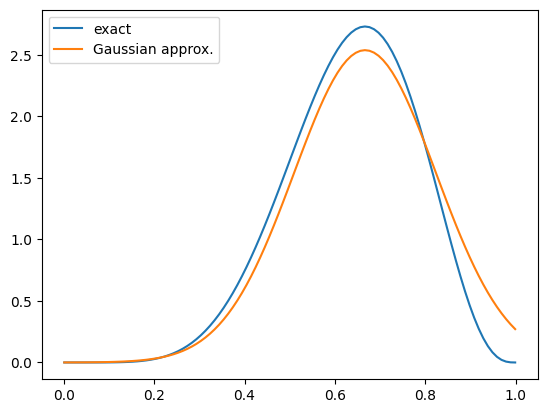

In [ ]:
x = torch.linspace(0.001, 0.999, 100)
y1 = Beta(6.+1, 3.+1).log_prob(x).exp()
y2 = Normal(p, stddev).log_prob(x).exp().detach()
plt.plot(x, y1, label="exact")
plt.plot(x, y2, label="Gaussian approx.")
plt.legend()
plt.show()

### Code 2.8
Use vanilla MCMC to infer the posterior distribution of $p$ for the globe model

In [ ]:
n_samples = 10000
p = list()
p.append(torch.tensor(0.5))
W = torch.tensor(6.)
L = torch.tensor(3.)
for i in range(1, n_samples):
    # Take a small step away from the previous sample
    p_new = Normal(p[i-1], 0.1).sample()
    # If the step is outside [0, 1], squish it back in there
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    # Get the likelihood of the previous/current step
    q0 = Binomial(W+L, p[i-1]).log_prob(W).exp()
    q1 = Binomial(W+L, p_new).log_prob(W).exp()
    # Reject the new sample if the likelihood ratio isn't high enough
    if Uniform(0, 1).sample() < q1/q0:
        p.append(p_new)
    else:
        p.append(p[i-1])

### Code 2.9
Plot the results of the MCMC simulation and compare with the analytical posterior

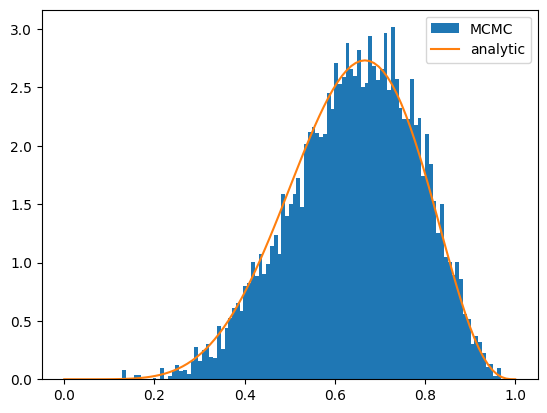

In [ ]:
plt.hist(p, bins=100, label="MCMC", density=True)
x = torch.linspace(0, 1, 100)
y = Beta(W+1, L+1).log_prob(x).exp()
plt.plot(x, y, label="analytic")
plt.legend()
plt.show()

### Advanced Estimators (Ignore)

In [ ]:
from pyro.infer import MCMC, NUTS
lifted_model = pyro.poutine.lift(model, prior={"p": Uniform(0.0, 1.0)})
#nuts = NUTS(pyro.poutine.condition(lifted_model, data={"obs": (6.,3.)}))
nuts = NUTS(lifted_model)
mcmc = MCMC(nuts, num_samples=20000, warmup_steps=5000, num_chains=1)
mcmc.run(6 , 3)
samples = mcmc.get_samples()
mcmc.summary()
precis(samples)

## Practice problems

### 2E1
Which of the expressions below correspond to the statement "the probability of rain on Monday"?
1. Pr(rain)
2. Pr(rain|Monday)
3. Pr(Monday|rain)
4. Pr(rain,Monday)/Pr(Monday)

### 2E2
Which of the following statements corresponds to the expression: Pr(Monday|rain)?
1. The probability of rain on Monday
2. The probability of rain, given that it is Monday
3. The probability that it is Monday, given that it is raining
4. The probability that it is Monday and that it is raining

### 2E3
Which of the expressions below correspond to the statement "the probability that it is Monday, given that it is raining"?

1. Pr(Monday|rain)
2. Pr(rain|Monday)
3. Pr(rain|Monday) Pr(Monday)
4. Pr(rain|Monday) Pr(Monday) / Pr(rain)
5. Pr(Monday|rain) P(rain) / Pr(Monday)

### 2E4
The Bayesian statistician Bruno de Finetti (1906–1985) began his book on probability theory
with the declaration: “PROBABILITY DOES NOT EXIST.” The capitals appeared in the original, so
I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a device
for describing uncertainty from the perspective of an observer with limited knowledge; it has no
objective reality. Discuss the globe tossing example, in light of this statement. What
does it mean to say “the probability of water is 0.7”?

### 2M1
Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for $p$:
1. W, W, W (W=3, L=0)
2. W, W, W, L (W=3, L=1)
3. L, W, W, L, W, W, W (W=5, L=2)

In [ ]:
def calc_posterior(W, L):
    p_grid = np.linspace(0, 1, 100)
    prior = np.ones(p_grid.shape)
    L = stats.binom(n=W+L, p=p_grid).pmf(W)
    posterior = L * prior
    posterior /= sum(posterior)
    return p_grid, posterior

In [ ]:
for W, L in ((3, 0), (3, 1), (5, 2)):
    x, y = calc_posterior(W, L)
    plt.plot(x, y, label=f"W={W}, L={L}")
plt.xlabel("$p$")
plt.ylabel("pdf")
plt.title("Posterior probability")
plt.legend()
plt.show()

### 2M2
Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when
p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of
observations in the problem just above.

Same as 2M1, but assume a step prior that is zero for $p < 0.5$ and constant otherwise.

In [ ]:
def calc_posterior(W, L):
    '''
    Returns p_grid & posterior
    '''
    pass

In [ ]:
for W, L in ((3, 0), (3, 1), (5, 2)):
    x, y = calc_posterior(W, L)
    plt.plot(x, y, label=f"W={W}, L={L}")
plt.xlabel("$p$")
plt.ylabel("pdf")
plt.title("Posterior probability")
plt.legend()
plt.show()

### 2M3
Suppose you have two globes, one for Earth and one for Mars. Earth has fraction 0.7 water, but Mars is 100% land. Show that the posterior probability that the globe is Earth, conditional on seeing land, is 0.23.

Ok, I'm going to do this a couple ways. First, the easy numerical simulation method. We compute Pr(Earth|land) by simulating a bunch tosses, tossing out any that don't result in land, and see what fraction of them are Earth

In [ ]:
def simulation(n_samples):
    '''
    returns two 1d tensors planets and terrains

    each sample is a pair of items planet (Earth/Mars) and terrian (W/L)
    Think about conditional probability.
    steps:
    - generate random planets using np.random.choice
    - generate random numbers to sample W and L
    - but take care of planet type when sampling because probability of W is different on earth and mars
    - loop over planet type
        - create as mask for each planet type
        - mask & p<w_prob then W else mask & p>=p_prob
    - return planets and terrian
    '''
    return planets, terrain

def calc_conditional_prob():
    '''
    computer Pr(earth | we observed L)
    '''
    planets, terrain = simulation(int(1e6))
    mask = (terrain == "L")
    planets = planets[mask]
    return sum(planets == "earth")/len(planets)

In [ ]:
calc_conditional_prob()

Then, we'll do it analytically. We assume that the Earth/Mars choice is a Bernoulli RV with $p=0.5$, so that Pr(Earth)=Pr(Mars)=1/2. The conditional probabilities Pr(land|Earth) = 0.3 and Pr(land|Mars) = 1, so from Bayes' rule we have:
$$
\begin{align}
Pr(\text{Earth}|\text{land}) & = Pr(\text{Earth}, \text{land})/Pr(\text{land}) \\
& = Pr(\text{land} | \text{Earth}) Pr(\text{Earth})/ Pr(\text{land}) \\
& = 0.3 * 0.5/ Pr(\text{land}) \\
& = 0.15/ \left[Pr(\text{land}|\text{Earth}) Pr(\text{Earth}) + Pr(\text{land}|\text{Mars}) Pr(\text{Mars})\right] \\
&= 0.15/\left[ 0.3*0.5 + 1*0.5 \right] \\
&\approx 0.2307
\end{align}
$$

In [ ]:
0.15/(0.3*0.5 + 1*0.5)

Next we'll use `pyro` to figure it out by sampling the model, then analyzing the samples

In [ ]:
# Specify model
def model():
    planet = pyro.sample("planet", Bernoulli(torch.tensor(0.5))) # 0=earth, 1=mars
    if planet == 0.0:
        terrain = pyro.sample("terrain", Bernoulli(torch.tensor(0.3))) # 0=water, 1=land
    else:
        terrain = pyro.sample("terrain", Bernoulli(torch.tensor(1.))) # 0=water, 1=land
    return planet, terrain

In [ ]:
# The Curious Curator version
N = 1000000
# sample
samples = torch.tensor([model() for i in range(N)])

planets = torch.tensor([s[0] for s in samples])
terrains = torch.tensor([s[1] for s in samples])

# calculate probability
# find samples where terrains = 1 (Land)
mask = (terrains==1)
# get planets when terrian = Land
planets = planets[mask]
p = (planets==0).sum()/len(planets)
print(p)

In [ ]:
# github version i don't like it. uselessly complicated
# Get model traces
planets = list()
terrains = list()

traced_model = pyro.poutine.trace(model)

N = 1000000
for _ in range(N):
    tr = traced_model.get_trace()
    planets.append(tr.nodes["planet"]["value"])
    terrains.append(tr.nodes["terrain"]["value"])
planets = np.array(planets)
terrains = np.array(terrains)

# Calculate probability
mask = (terrains == 1)
planets = planets[mask]
sum(planets == 0)/len(planets)